**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Z-критерий для двух долей 

In [1]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
import scipy
import statsmodels
print(np.__version__)
print(pd.__version__)
print(scipy.__version__)
print(statsmodels.__version__)

1.18.5
1.0.5
1.5.0
0.11.1


## Загрузка данных

In [2]:
data = pd.read_csv('banner_click_stat.txt', header = None, sep = '\t')
data.columns = ['banner_a', 'banner_b']

In [3]:
data.head()

,banner_a,banner_b
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


In [4]:
data.describe()

,banner_a,banner_b
count,1000.000000,1000.000000
mean,0.037000,0.053000
std,0.188856,0.224146
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [18]:
banner_a = 2560
banner_b = 2562
banner_a_N = 3200
banner_b_N = 3050

## Интервальные оценки долей

$$\frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{z^2}{4n^2} } \right), \;\; z \equiv z_{1-\frac{\alpha}{2}}$$ 

In [4]:
conf_interval_banner_a = proportion_confint(banner_a, 
                                            banner_a_N,
                                            method = 'wilson')
conf_interval_banner_b = proportion_confint(banner_b, 
                                            banner_b_N,
                                            method = 'wilson')

In [5]:
print('95%% confidence interval for a click probability, banner a: [%f, %f]' % conf_interval_banner_a)
print('95%% confidence interval for a click probability, banner b [%f, %f]' % conf_interval_banner_b)

95% confidence interval for a click probability, banner a: [0.383156, 0.417084]
95% confidence interval for a click probability, banner b [0.402595, 0.437606]


## Z-критерий для разности долей (независимые выборки)

  |       | $X_1$ | $X_2$  |  
  |-------|-------|--------|
  |1      | a     | b      | 
  |0      | c     | d      |  
  |$\sum$ | $n_1$ | $n_2$  | 
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [6]:
def proportions_diff_confint_ind(sample1_1, sample1_N, sample2_1, sample2_N, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sample1_1) / sample1_N
    p2 = float(sample1_1) / sample2_N
    
    left_boundary  = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ sample1_N + p2 * (1 - p2)/ sample2_N)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ sample1_N + p2 * (1 - p2)/ sample2_N)
    
    return (left_boundary, right_boundary)

In [7]:
def proportions_diff_z_stat_ind(sample1_1, sample1_N, sample2_1, sample2_N):
    n1 = sample1_N
    n2 = sample2_N
    
    p1 = float(sample1_1) / n1
    p2 = float(sample2_1) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [8]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [9]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(banner_a, banner_a_N, banner_b, banner_b_N))

95% confidence interval for a difference between proportions: [-0.044062, 0.004718]


In [10]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(banner_a, banner_a_N, banner_b, banner_b_N)))

p-value: 0.108038


In [13]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(banner_a, banner_a_N, banner_b, banner_b_N), 'less'))

p-value: 0.000020


## baessian

In [16]:
from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [21]:
from scipy.stats import beta
import numpy as np
#from calc_prob import calc_prob_between

#This is the known data: impressions and conversions for the Control and Test set
imps_ctrl,convs_ctrl=3200, 2560
imps_test, convs_test=3050, 2562

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

#calculating the probability for Test to be better than Control
prob=calc_prob_between(beta_T, beta_C)

print (f"Test option lift Conversion Rates by {lift*100:2.2f}% with {prob*100:2.1f}% probability.")
#output: Test option lift Conversion Rates by 59.68% with 98.2% probability.

Test option lift Conversion Rates by 5.00% with 100.0% probability.


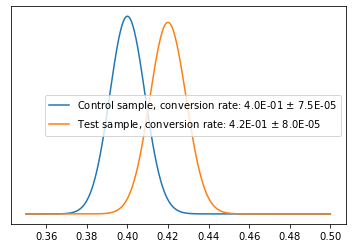

In [27]:
import matplotlib.pyplot as plt

def calc_beta_mode(a, b):
    '''this function calculate the mode (peak) of the Beta distribution'''
    return (a-1)/(a+b-2)

def plot(betas, names, linf=0.35, lsup=0.5):
    '''this function plots the Beta distribution'''
    x=np.linspace(linf,lsup, 1000)
    for f, name in zip(betas,names) :
        y=f.pdf(x) #this for calculate the value for the PDF at the specified x-points
        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # the variance of the Beta distribution
        plt.plot(x,y, label=f"{name} sample, conversion rate: {y_mode:0.1E} $\pm$ {y_var:0.1E}")
        plt.yticks([])
    plt.legend()
    plt.show()

plot([beta_C, beta_T], names=["Control", "Test"])